## Imports

In [6]:
from os import walk
from os.path import join

import pandas as pd
import numpy as np

import matplotlib.pyplot as plt

import nltk
from nltk.stem import PorterStemmer
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize

from bs4 import BeautifulSoup
from wordcloud import WordCloud

from sklearn.model_selection import train_test_split

from PIL import Image
%matplotlib inline

## Constants


In [79]:
EXAMPLE_FILE = 'C:/Users/Kiran Bharadwaj HD/Machine Learning/SpamData/01_Processing/practice_email.txt'

SPAM_1_PATH = 'SpamData/01_Processing/spam_assassin_corpus/spam_1'
SPAM_2_PATH = 'C:/Users/Kiran Bharadwaj HD/Machine Learning/SpamData/01_Processing/spam_assassin_corpus/spam_2'
EASY_NONSPAM_1_PATH = 'C:/Users/Kiran Bharadwaj HD/Machine Learning/SpamData/01_Processing/spam_assassin_corpus/easy_ham_1'
EASY_NONSPAM_2_PATH = 'C:/Users/Kiran Bharadwaj HD/Machine Learning/SpamData/01_Processing/spam_assassin_corpus/easy_ham_2'

SPAM_CAT = 1
HAM_CAT = 0
VOCAB_SIZE=2500

DATA_JSON_FILE = 'C:/Users/Kiran Bharadwaj HD/Machine Learning/SpamData/01_Processing/email-text-data.json'
WORD_ID_FILE=  'C:/Users/Kiran Bharadwaj HD/Machine Learning/SpamData/01_Processing/word-by-id.csv'
TRAINING_DATA_FILE = 'SpamData/02_Training/train-data.txt'
TEST_DATA_FILE = 'SpamData/02_Training/test-data.txt'
THUMBS_UP_FILE='SpamData/01_Processing/wordcloud_resources/thumbs-up.png'
THUMBS_DOWN_FILE='SpamData/01_Processing/wordcloud_resources/thumbs-down.png'
FONT_FILE='SpamData/01_Processing/wordcloud_resources/OpenSansCondensed-Bold.ttf'

## Reading Files

In [8]:
stream = open(EXAMPLE_FILE, encoding='latin-1')
message = stream.read()
stream.close()

print (message)

From exmh-workers-admin@redhat.com  Thu Aug 22 12:36:23 2002
Return-Path: <exmh-workers-admin@spamassassin.taint.org>
Delivered-To: zzzz@localhost.netnoteinc.com
Received: from localhost (localhost [127.0.0.1])
	by phobos.labs.netnoteinc.com (Postfix) with ESMTP id D03E543C36
	for <zzzz@localhost>; Thu, 22 Aug 2002 07:36:16 -0400 (EDT)
Received: from phobos [127.0.0.1]
	by localhost with IMAP (fetchmail-5.9.0)
	for zzzz@localhost (single-drop); Thu, 22 Aug 2002 12:36:16 +0100 (IST)
Received: from listman.spamassassin.taint.org (listman.spamassassin.taint.org [66.187.233.211]) by
    dogma.slashnull.org (8.11.6/8.11.6) with ESMTP id g7MBYrZ04811 for
    <zzzz-exmh@spamassassin.taint.org>; Thu, 22 Aug 2002 12:34:53 +0100
Received: from listman.spamassassin.taint.org (localhost.localdomain [127.0.0.1]) by
    listman.redhat.com (Postfix) with ESMTP id 8386540858; Thu, 22 Aug 2002
    07:35:02 -0400 (EDT)
Delivered-To: exmh-workers@listman.spamassassin.taint.org
Received: from int-mx1.corp

In [9]:
import sys
sys.getfilesystemencoding()

'utf-8'

In [10]:
## Extracting e-mail body
stream = open(EXAMPLE_FILE, encoding='latin-1')
is_body=False
lines=[]
for line in stream:
    if is_body:
        lines.append(line)
    elif line == '\n':
        is_body = True
    
stream.close()
email_body='\n'.join(lines)
print (email_body)



Dear Mr Still



Good tidings to you and all your staff for the festive season ahead (Christmas).

Now to the crux of the matter-in-hand: I am a fully qualified Santa Claus and am wondering whether you might consider me to run my own "Santa's Grotto" in your store.

But WAIT! You're probably thinking: "What makes him so special?"

Well, first of all, I have made several changes to the characterisation of Father Christmas. Rather than greeting the children with shouts of "Ho, ho, ho!" I prefer to whisper the phrase "Dependence is not unfathomable in this cruel world we live in". In addition, my gifts are ALL hand-made, ranging from felt hoops to vanilla-pod holders.

You will note also, from the enclosed sketch, that I have radically redesigned Santa's outfit and have renamed my character "Lord Buckles". Would you be interested in employing me? I promise NEVER to let you down.

I look forward to hearing from you.



Best wishes

Robin Cooper

[Excerpt from the book: The Timewaster Let

## Generator Functions

In [11]:
def generate_squares(N):
    for my_number in range(N):
        yield my_number**2

In [12]:
for i in generate_squares(5):
    print(i, end='->')

0->1->4->9->16->

## E-Mail Body Extraction

In [13]:
def email_body_generator(path):
    for root, dirnames, filenames in walk(path):
        
        for file_name in filenames:
            
            filepath=join(root, file_name)
            stream = open(filepath, encoding='latin-1')
            is_body=False
            lines=[]
            for line in stream:
                if is_body:
                    lines.append(line)
                elif line == '\n':
                    is_body = True

            stream.close()
            email_body='\n'.join(lines)
            yield file_name, email_body

In [14]:
def df_from_directory(path, classification):
    rows=[]
    row_names = []
    for file_name, email_body in email_body_generator(path):
        rows.append({'MESSAGE': email_body, 'CATEGORY':classification})
        row_names.append(file_name)
        
    return pd.DataFrame(rows, index=row_names)

In [15]:
spam_emails = df_from_directory(SPAM_1_PATH, 1)
spam_emails = spam_emails.append(df_from_directory(SPAM_2_PATH, 1))
spam_emails.shape

C:\Users\Kiran Bharadwaj HD\AppData\Local\Temp\ipykernel_4424\1594863529.py:2: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  spam_emails = spam_emails.append(df_from_directory(SPAM_2_PATH, 1))


(1898, 2)

In [16]:
ham_emails = df_from_directory(EASY_NONSPAM_1_PATH, 0)
ham_emails = ham_emails.append(df_from_directory(EASY_NONSPAM_2_PATH, 0))
ham_emails.shape

C:\Users\Kiran Bharadwaj HD\AppData\Local\Temp\ipykernel_4424\167656062.py:2: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ham_emails = ham_emails.append(df_from_directory(EASY_NONSPAM_2_PATH, 0))


(3901, 2)

In [17]:
data = pd.concat([spam_emails, ham_emails])
print('Shape of entire dataframe is ', data.shape)
data.tail()

Shape of entire dataframe is  (5799, 2)


,MESSAGE,CATEGORY
01396.61983fbe6ec43f55fd44e30fce24ffa6,http://news.bbc.co.uk/1/hi/england/2515127.stm...,0
01397.9f9ef4c2a8dc012d80f2ce2d3473d3b7,"> >-- be careful when using this one.) Also, t...",0
01398.169b51731fe569f42169ae8f948ec676,">>>>> ""SM"" == Skip Montanaro <skip@pobox.com> ...",0
01399.ca6b00b7b341bbde9a9ea3dd6a7bf896,"So then, ""Mark Hammond"" <mhammond@skippinet.co...",0
01400.f897f0931e461e7b2e964d28e927c35e,"Hi there,\n\n\n\nNow this is probably of no us...",0


## Data Cleaning : Check for Missing Values

In [18]:
data.MESSAGE.isnull().values.any()

False

In [19]:
# Check if there are empty emails
(data.MESSAGE.str.len() == 0 ).sum()

3

### Locate empty emails 

In [20]:
data[data.MESSAGE.str.len()==0].index

Index(['cmds', 'cmds', 'cmds'], dtype='object')

## Remove System File Entries From DataFrame

In [21]:
data.drop(['cmds'], inplace=True)

In [22]:
data.shape

(5796, 2)

## Add Document IDs to Track Emails in Dataset

In [23]:
document_ids = range(0, len(data.index))
data['DOC_ID']=document_ids

In [24]:
data['FILE_NAME'] = data.index
data= data.set_index('DOC_ID')
print(data)

                                                  MESSAGE  CATEGORY  \
DOC_ID                                                                
0       <!DOCTYPE HTML PUBLIC "-//W3C//DTD HTML 4.0 Tr...         1   
1       1) Fight The Risk of Cancer!\n\nhttp://www.adc...         1   
2       1) Fight The Risk of Cancer!\n\nhttp://www.adc...         1   
3       ##############################################...         1   
4       I thought you might like these:\n\n1) Slim Dow...         1   
...                                                   ...       ...   
5791    http://news.bbc.co.uk/1/hi/england/2515127.stm...         0   
5792    > >-- be careful when using this one.) Also, t...         0   
5793    >>>>> "SM" == Skip Montanaro <skip@pobox.com> ...         0   
5794    So then, "Mark Hammond" <mhammond@skippinet.co...         0   
5795    Hi there,\n\n\n\nNow this is probably of no us...         0   

                                     FILE_NAME  
DOC_ID                     

## Save to File using Pandas

In [25]:
data.to_json(DATA_JSON_FILE)

## Number of Spam Messages Visualised (Pie and Donut Charts)

In [26]:
data.CATEGORY.value_counts()

0    3900
1    1896
Name: CATEGORY, dtype: int64

In [27]:
amount_of_spam = data.CATEGORY.value_counts()[1]
amount_of_ham = data.CATEGORY.value_counts()[0]

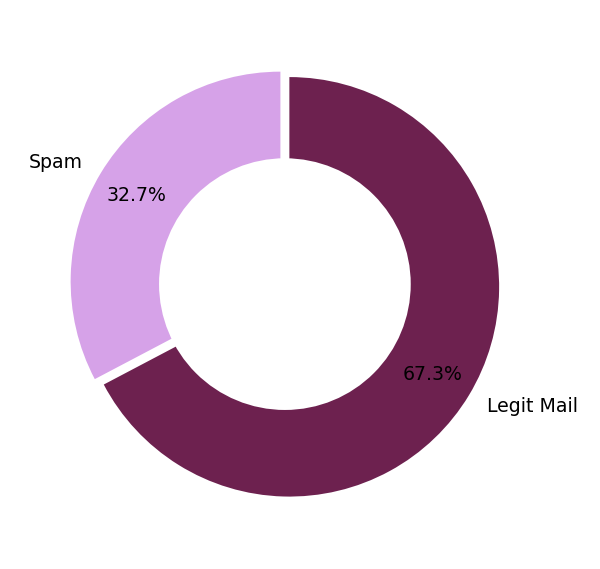

In [28]:
category_names = ['Spam', 'Legit Mail']
sizes = [amount_of_spam, amount_of_ham]
plt.figure(figsize=(3,3),dpi=227)
col_custom=['#D6A2E8','#6D214F']
plt.pie(sizes, labels=category_names, textprops={'fontsize':6}, startangle=90,
        autopct='%1.1f%%', colors=col_custom, pctdistance=0.8, explode=(0.025,0.025) )

# draw circle for donutting :)

centre_circle = plt.Circle((0,0), radius=0.6, fc='white')
plt.gca().add_artist(centre_circle)
plt.show()

## Natural Language Processing

### Text Pre-Processing
#### Lower casing    
#### tokenising
#### removing stop words 

#### NLTK Resources Download

In [29]:
nltk.download('punkt')
nltk.download('stopwords')

[nltk_data] Downloading package punkt to C:\Users\Kiran Bharadwaj
[nltk_data]     HD\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to C:\Users\Kiran Bharadwaj
[nltk_data]     HD\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [30]:
stop_words = set(stopwords.words('english'))
stemmer = PorterStemmer()


## Function for Email Processing

In [31]:
def clean_message_no_html(message, stemmer=PorterStemmer(), 
                  stop_words=set(stopwords.words('english'))):
    # Removes HTML tags
    soup = BeautifulSoup(message, 'html.parser')
    cleaned_text = soup.get_text()
    # Converts to lower case and splits up the words
    words = word_tokenize(cleaned_text.lower())
    
    filtered_words = []
    
    for word in words:
        # Removes the stop words and punctuations ultimately stems it
        if word not in stop_words and word.isalpha():
            filtered_words.append(stemmer.stem(word))
    
    return filtered_words     

In [32]:
clean_message_no_html(email_body)

['dear',
 'mr',
 'still',
 'good',
 'tide',
 'staff',
 'festiv',
 'season',
 'ahead',
 'christma',
 'crux',
 'fulli',
 'qualifi',
 'santa',
 'clau',
 'wonder',
 'whether',
 'might',
 'consid',
 'run',
 'santa',
 'grotto',
 'store',
 'wait',
 'probabl',
 'think',
 'make',
 'special',
 'well',
 'first',
 'made',
 'sever',
 'chang',
 'characteris',
 'father',
 'christma',
 'rather',
 'greet',
 'children',
 'shout',
 'ho',
 'ho',
 'ho',
 'prefer',
 'whisper',
 'phrase',
 'depend',
 'unfathom',
 'cruel',
 'world',
 'live',
 'addit',
 'gift',
 'rang',
 'felt',
 'hoop',
 'holder',
 'note',
 'also',
 'enclos',
 'sketch',
 'radic',
 'redesign',
 'santa',
 'outfit',
 'renam',
 'charact',
 'lord',
 'buckl',
 'would',
 'interest',
 'employ',
 'promis',
 'never',
 'let',
 'look',
 'forward',
 'hear',
 'best',
 'wish',
 'robin',
 'cooper',
 'excerpt',
 'book',
 'timewast',
 'letter',
 'robin',
 'cooper']

## Apply Cleaning and Tokenisation to all the messages

### Slicing DataFrame and Series and Creating Subsets

In [33]:
first_emails=data.MESSAGE.iloc[0:3]
nested_list=first_emails.apply(clean_message_no_html)

In [34]:
flat_list=[]
# for sublist in nested_list:
#     for item in sublist:
#         flat_list.append(item)
flat_list = [item for sublist in nested_list for item in sublist]
len(flat_list)

192

In [35]:
%%time

nested_list = data.MESSAGE.apply(clean_message_no_html)

C:\Users\Kiran Bharadwaj HD\anaconda3\lib\site-packages\bs4\__init__.py:435: MarkupResemblesLocatorWarning: The input looks more like a filename than markup. You may want to open this file and pass the filehandle into Beautiful Soup.
  warnings.warn(
C:\Users\Kiran Bharadwaj HD\anaconda3\lib\site-packages\bs4\__init__.py:404: MarkupResemblesLocatorWarning: The input looks more like a URL than markup. You may want to use an HTTP client like requests to get the document behind the URL, and feed that document to Beautiful Soup.
  warnings.warn(


Wall time: 23.8 s


In [36]:
nested_list.tail()

DOC_ID
5791    [http, bizarr, collect, stuf, anim, could, fet...
5792    [care, use, one, also, realli, cute, thing, ja...
5793    [sm, skip, montanaro, write, jeremi, put, anot...
5794    [mark, hammond, like, given, zodb, sound, attr...
5795    [hi, probabl, use, whatsoev, also, problem, re...
Name: MESSAGE, dtype: object

In [37]:
# Challenge: Modify function to remove HTML tags. Then test on Email with DOC_ID 2. 
def clean_msg_no_html(message, stemmer=PorterStemmer(), 
                 stop_words=set(stopwords.words('english'))):
    
    # Remove HTML tags
    soup = BeautifulSoup(message, 'html.parser')
    cleaned_text = soup.get_text()
    
    # Converts to Lower Case and splits up the words
    words = word_tokenize(cleaned_text.lower())
    
    filtered_words = []
    
    for word in words:
        # Removes the stop words and punctuation
        if word not in stop_words and word.isalpha():
            filtered_words.append(stemmer.stem(word))
             #filtered_words.append(word) 
    
    return filtered_words

In [38]:
doc_ids_spam = data[data.CATEGORY == 1].index
doc_ids_ham = data[data.CATEGORY == 0].index
doc_ids_ham

Int64Index([1896, 1897, 1898, 1899, 1900, 1901, 1902, 1903, 1904, 1905,
            ...
            5786, 5787, 5788, 5789, 5790, 5791, 5792, 5793, 5794, 5795],
           dtype='int64', name='DOC_ID', length=3900)

### Subsetting a series with an index

In [39]:
type(doc_ids_ham)

pandas.core.indexes.numeric.Int64Index

In [40]:
type(nested_list)

pandas.core.series.Series

In [41]:
nested_list_ham=nested_list.loc[doc_ids_ham]

In [42]:
nested_list_ham.shape

(3900,)

In [43]:
nested_list_spam=nested_list.loc[doc_ids_spam]

In [44]:
nested_list_spam.shape


(1896,)

In [45]:
 flat_list_ham=[item for sublist in nested_list_ham for item in sublist]
normal_words = pd.Series(flat_list_ham).value_counts()
normal_words.shape[0]

20814

In [46]:
normal_words[:10]


http      7563
use       3633
list      2880
one       2373
get       2286
mail      2255
would     2003
like      1931
messag    1849
work      1800
dtype: int64

In [47]:
flat_list_spam=[item for sublist in nested_list_spam for item in sublist]
spammy_words = pd.Series(flat_list_spam).value_counts()
spammy_words.shape[0]

13241

In [48]:
spammy_words[:10]

http      3097
email     3090
free      2585
click     2058
receiv    1989
list      1971
get       1914
pleas     1852
busi      1792
order     1746
dtype: int64

## WordCloud


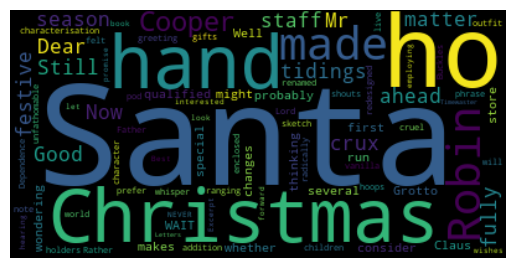

In [45]:
word_cloud=WordCloud().generate(email_body)
plt.imshow(word_cloud, interpolation='bilinear')
plt.axis('off')
plt.show()

In [46]:
nltk.download('gutenberg')
nltk.download('shakespeare')


[nltk_data] Downloading package gutenberg to C:\Users\Kiran Bharadwaj
[nltk_data]     HD\AppData\Roaming\nltk_data...
[nltk_data]   Package gutenberg is already up-to-date!
[nltk_data] Downloading package shakespeare to C:\Users\Kiran
[nltk_data]     Bharadwaj HD\AppData\Roaming\nltk_data...
[nltk_data]   Package shakespeare is already up-to-date!


True

In [47]:
example_corpus=nltk.corpus.gutenberg.words('melville-moby_dick.txt')
len(example_corpus)

260819

In [48]:
word_list=[''.join(word) for word in example_corpus]
novel_as_string=' '.join(word_list)

In [49]:
icon=Image.open(WHALE_FILE)
image_mask=Image.new(mode='RGB', size=icon.size, color=(255,255,255))
image_mask.paste(icon, box=icon)

rgb_array=np.array(image_mask)

word_cloud=WordCloud(mask=rgb_array, background_color='white', max_words=400)
word_cloud.generate(novel_as_string)

plt.figure(figsize=[16,8])
plt.imshow(word_cloud, interpolation='bilinear')
plt.axis('off')
plt.show()

NameError: name 'WHALE_FILE' is not defined

In [54]:
example_corpus=nltk.corpus.gutenberg.words('shakespeare-hamlet.txt')

word_list=[''.join(word) for word in example_corpus]
novel_as_string=' '.join(word_list)

icon=Image.open(SKULL_FILE)
image_mask=Image.new(mode='RGB', size=icon.size, color=(255,255,255))
image_mask.paste(icon, box=icon)

rgb_array=np.array(image_mask)

word_cloud=WordCloud(mask=rgb_array, background_color='white', max_words=600)
word_cloud.generate(novel_as_string)

plt.figure(figsize=[16,8])
plt.imshow(word_cloud, interpolation='bilinear')
plt.axis('off')
plt.show()

NameError: name 'SKULL_FILE' is not defined

## Word Cloud of Ham and Spam Messages

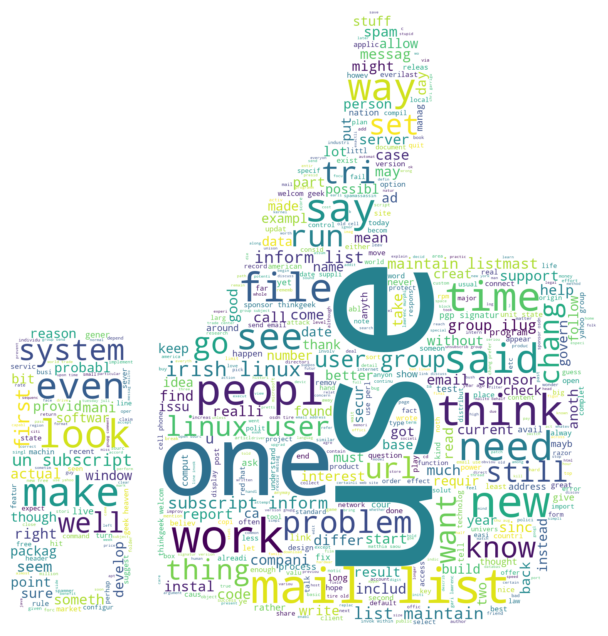

In [55]:
ham_str=' '.join(flat_list_ham)

icon=Image.open(THUMBS_UP_FILE)
image_mask=Image.new(mode='RGB', size=icon.size, color=(255,255,255))
image_mask.paste(icon, box=icon)

rgb_array=np.array(image_mask)

word_cloud=WordCloud(mask=rgb_array, background_color='white', max_words=600)
word_cloud.generate(ham_str)

plt.figure(figsize=[16,8])
plt.imshow(word_cloud, interpolation='bilinear')
plt.axis('off')
plt.show()

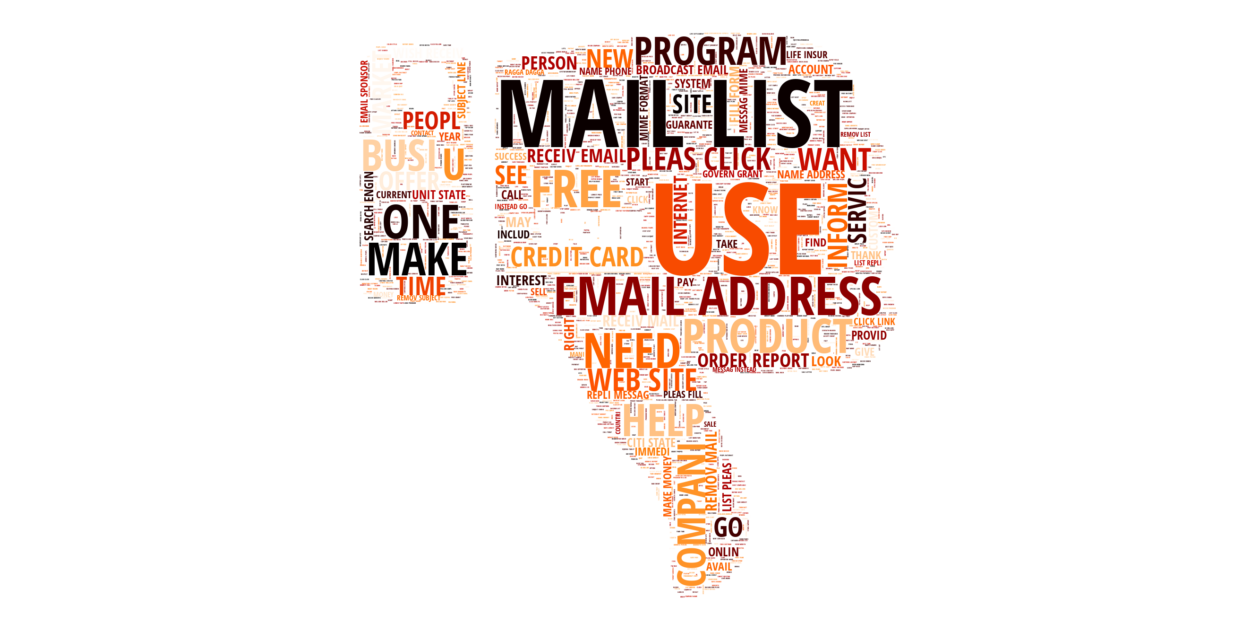

In [79]:
spam_str=' '.join(flat_list_spam)

icon=Image.open(THUMBS_DOWN_FILE)
image_mask=Image.new(mode='RGB', size=icon.size, color=(255,255,255))
image_mask.paste(icon, box=icon)

rgb_array=np.array(image_mask)

word_cloud=WordCloud(mask=rgb_array, background_color='white', 
                         max_words=2000, colormap='gist_heat', font_path=FONT_FILE)
word_cloud.generate(spam_str.upper())

plt.figure(figsize=[16,8])
plt.imshow(word_cloud, interpolation='bilinear')
plt.axis('off')
plt.show()

## Generate Vocabulary & Dictionary

In [49]:
stemmed_nested_list = data.MESSAGE.apply(clean_msg_no_html)
print(stemmed_nested_list)
flat_stemmed_list = [ item  for sublist in stemmed_nested_list for item in sublist]

C:\Users\Kiran Bharadwaj HD\anaconda3\lib\site-packages\bs4\__init__.py:435: MarkupResemblesLocatorWarning: The input looks more like a filename than markup. You may want to open this file and pass the filehandle into Beautiful Soup.
  warnings.warn(
C:\Users\Kiran Bharadwaj HD\anaconda3\lib\site-packages\bs4\__init__.py:404: MarkupResemblesLocatorWarning: The input looks more like a URL than markup. You may want to use an HTTP client like requests to get the document behind the URL, and feed that document to Beautiful Soup.
  warnings.warn(


DOC_ID
0       [save, life, insur, spend, life, quot, save, g...
1       [fight, risk, cancer, http, slim, guarante, lo...
2       [fight, risk, cancer, http, slim, guarante, lo...
3       [adult, club, offer, free, membership, instant...
4       [thought, might, like, slim, guarante, lose, l...
                              ...                        
5791    [http, bizarr, collect, stuf, anim, could, fet...
5792    [care, use, one, also, realli, cute, thing, ja...
5793    [sm, skip, montanaro, write, jeremi, put, anot...
5794    [mark, hammond, like, given, zodb, sound, attr...
5795    [hi, probabl, use, whatsoev, also, problem, re...
Name: MESSAGE, Length: 5796, dtype: object


In [50]:
unique_words=pd.Series(flat_stemmed_list).value_counts()
unique_words

http        10660
use          5019
list         4851
email        4367
get          4200
            ...  
zarzycki        1
stw             1
canyon          1
wmv             1
oreilli         1
Length: 27332, dtype: int64

In [51]:
frequent_words=unique_words[0:VOCAB_SIZE]

In [52]:
frequent_words

http         10660
use           5019
list          4851
email         4367
get           4200
             ...  
till            44
corn            43
analog          43
apach           43
overnight       43
Length: 2500, dtype: int64

## Create Vocabulary DataFrame with a WORD_ID

In [53]:
word_ids = list(range(0,VOCAB_SIZE))
vocab = pd.DataFrame({'VOCAB_WORD':frequent_words.index.values}, index=word_ids)
vocab.index.name= 'WORD_ID'
vocab.head()

,VOCAB_WORD
WORD_ID,
0,http
1,use
2,list
3,email
4,get


## Save Vocab As CSV File (Complete TOP 2500 Vocab Words)

In [54]:
vocab.to_csv(WORD_ID_FILE, index_label=vocab.index.name, header=vocab.VOCAB_WORD.name)

## Check if the word is in the Vocabulary

In [55]:
def word_present(word):
    if word in set(vocab.VOCAB_WORD):
        return True
    else:
        return False

In [56]:
word_present('bre')

False

## Finding Longest Mail

In [57]:
clean_email_lengths = []
for sublist in stemmed_nested_list:
    clean_email_lengths.append(len(sublist))
## clean_email_lengths = [len(sublist) for sublist in stemmed_nested_list]

In [58]:
np.argmax(clean_email_lengths)

5775

In [59]:
data.at[np.argmax(clean_email_lengths), 'MESSAGE']

'------------------------ Yahoo! Groups Sponsor ---------------------~-->\n\n4 DVDs Free +s&p Join Now\n\nhttp://us.click.yahoo.com/pt6YBB/NXiEAA/Ey.GAA/26EolB/TM\n\n---------------------------------------------------------------------~->\n\n\n\nA new version of unison is now available for testing.  It incorporates\n\nseveral small improvements over 2.9.1, but the main change is a fix to\n\na bug that had potentially serious safety consequences, but only for\n\nthe very small number of users that are in the habit of running more\n\nthan one instance of Unison at a time, in parallel.  These users are\n\nstrongly encouraged to upgrade.  Others can wait if they wish.\n\n\n\nThe release includes pre-built executables for Linux and Solaris, but\n\nnot Windows.  (We are looking for a Unison-Windows maintainer -- at\n\nthe moment, none of the active developers are regularly using Unison\n\non Windows, and we do not have a machine that is configured properly\n\nfor building executables for exp

## Generate Features & a Sparse Matrix

In [60]:
stemmed_nested_list

DOC_ID
0       [save, life, insur, spend, life, quot, save, g...
1       [fight, risk, cancer, http, slim, guarante, lo...
2       [fight, risk, cancer, http, slim, guarante, lo...
3       [adult, club, offer, free, membership, instant...
4       [thought, might, like, slim, guarante, lose, l...
                              ...                        
5791    [http, bizarr, collect, stuf, anim, could, fet...
5792    [care, use, one, also, realli, cute, thing, ja...
5793    [sm, skip, montanaro, write, jeremi, put, anot...
5794    [mark, hammond, like, given, zodb, sound, attr...
5795    [hi, probabl, use, whatsoev, also, problem, re...
Name: MESSAGE, Length: 5796, dtype: object

In [61]:
word_columns_df=pd.DataFrame.from_records(stemmed_nested_list.tolist())
word_columns_df.head()

,0,1,2,3,4,5,6,7,8,9,...,7661,7662,7663,7664,7665,7666,7667,7668,7669,7670
0,save,life,insur,spend,life,quot,save,g,famili,financi,...,None,None,None,None,None,None,None,None,None,None
1,fight,risk,cancer,http,slim,guarante,lose,lb,day,http,...,None,None,None,None,None,None,None,None,None,None
2,fight,risk,cancer,http,slim,guarante,lose,lb,day,http,...,None,None,None,None,None,None,None,None,None,None
3,adult,club,offer,free,membership,instant,access,site,user,name,...,None,None,None,None,None,None,None,None,None,None
4,thought,might,like,slim,guarante,lose,lb,day,http,fight,...,None,None,None,None,None,None,None,None,None,None


## Splitting the data into training and testing Dataset

In [62]:
X_train, X_test, y_train, y_test = train_test_split(word_columns_df, data.CATEGORY,
                                                    test_size=0.3, random_state=42) 

In [63]:
X_train.index.name = X_test.index.name = 'DOC_ID'

In [64]:
X_train.head()

,0,1,2,3,4,5,6,7,8,9,...,7661,7662,7663,7664,7665,7666,7667,7668,7669,7670
DOC_ID,,,,,,,,,,,,,,,,,,,,,
4844,ye,inde,agent,directori,verita,cd,unix,subdirectori,file,call,...,None,None,None,None,None,None,None,None,None,None
4727,problem,come,tri,instal,harddissssk,like,alreadi,mount,http,yahoo,...,None,None,None,None,None,None,None,None,None,None
5022,origin,messag,date,mon,aug,chad,norwood,sven,cc,subject,...,None,None,None,None,None,None,None,None,None,None
3504,inlin,folk,sever,major,internet,outag,morn,across,major,provid,...,None,None,None,None,None,None,None,None,None,None
3921,url,http,date,bath,chronicl,None,None,None,None,None,...,None,None,None,None,None,None,None,None,None,None


## Create a Sparse Matrix for the Training Data

In [65]:
word_index= pd.Index(vocab.VOCAB_WORD)

In [66]:
def make_sparse_matrix(df, indexed_words, labels):
    """
    Returns sparse matrix as dataframe.
    
    df: A dataframe with words in the column with a document id as an index (X_train or X_test)
    indexed_words: index of words ordered by word id
    labels: category as a series (y_train or y_test)
    """
    nr_rows = df.shape[0]
    nr_cols = df.shape[1]
    word_set = set(indexed_words)
    dict_list = []
    
    for i in range(nr_rows):
        for j in range(nr_cols):
            word = df.iat[i,j]
            if word in word_set:
                doc_id = df.index[i];
                word_id = indexed_words.get_loc(word)
                category = labels.at[doc_id]
                item = {'LABEL': category,'DOC_ID': doc_id, 'OCCURENCE': 1, 'WORD_ID': word_id}
                dict_list.append(item)
    return pd.DataFrame(dict_list)

In [67]:
%%time
sparse_train_df = make_sparse_matrix(X_train, word_index, y_train)

Wall time: 4min 58s


In [68]:
sparse_train_df

,LABEL,DOC_ID,OCCURENCE,WORD_ID
0,0,4844,1,265
1,0,4844,1,1239
2,0,4844,1,504
3,0,4844,1,308
4,0,4844,1,254
...,...,...,...,...
429179,1,860,1,47
429180,1,860,1,1431
429181,1,860,1,26
429182,1,860,1,21


## Combine Occurrences with the Pandas groupby() Method

In [69]:
train_grouped = sparse_train_df.groupby(['DOC_ID', 'WORD_ID', 'LABEL']).sum()

In [71]:
train_grouped = train_grouped.reset_index()

In [73]:
train_grouped.tail()

,DOC_ID,WORD_ID,LABEL,OCCURENCE
258327,5795,2032,0,2
258328,5795,2037,0,1
258329,5795,2271,0,1
258330,5795,2348,0,1
258331,5795,2379,0,1


In [78]:
vocab.at[1992, 'VOCAB_WORD']

'nvidia'

## Save Training Data as.txt File

In [77]:
np.savetxt(TRAINING_DATA_FILE, train_grouped, fmt='%d')

## Test Data Make-up

In [82]:
%%time
sparse_test_df = make_sparse_matrix(X_test, word_index, y_test)

Wall time: 2min 12s


In [85]:
test_grouped = sparse_test_df.groupby(['DOC_ID', 'WORD_ID', 'LABEL']).sum().reset_index()
np.savetxt(TEST_DATA_FILE, test_grouped, fmt='%d')